# Simple Marketing Test

* Evolving test environment to simulate marketing to customers.
* Initially each episode is a customer, and customers have their entire lifecycle processed sequentially.

Recommend running in **jupyter notebook** as the interactive parts may not work in jupyter lab without installing and enabling certain nbextensions.

In [7]:
import random 
import numpy as np
import sys
import platform

if platform.system == 'Windows':
    # not tested
    if '..' not in sys.path:
        sys.path.append('..')
else:
    if "../" not in sys.path:
        sys.path.append("../") 


from lib.envs.simple_marketing import TwoValueMarketingEnv, SimpleMarketingEnv, Customer, CustomerInventoryDriven
from lib.simulation import Experiment

class Agent(object):  
        
    def __init__(self, actions):
        self.actions = actions
        self.num_actions = len(actions)

    def act(self, state):
        raise NotImplementedError
        
        
class SarsaAgent(Agent):
    
    def __init__(self, actions, print_rewards=True, epsilon=0.01, alpha=0.5, gamma=1):
        super(SarsaAgent, self).__init__(actions)
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.sadict = {}
        self.progress = 0
        self.print_rewards = print_rewards
        print('Epsilon is set at %f' % self.epsilon)
        print('Alpha is set at %f' % self.alpha)
        print('Gamma is set at %f' % self.gamma)
        self.action_choices = actions
        print('Actions available are %s' % actions)
        
        
    def stateToString(self, state):
        mystring = ""
        if np.isscalar(state):
            mystring = str(state)
            #print('scalar %s becomes %s' % (state, mystring))
        else:
            for digit in state:
                mystring += str(digit)
            #print('non scalar %s becomes %s' % (state, mystring))
        return mystring    
    
    def initialize_state(self, statestr):
        self.sadict[statestr] = {}
        for action in self.action_choices:
            self.sadict[statestr][action] = 0

    def print_final_statistics(self):
        """
        Function added to allow visualization of state at end
        """
        print('sarsa state action value dictionary')
        for cntr, k in enumerate(self.sadict):
            max_action_value = -99999999
            max_action = ''
            print('%d: %s' % (cntr, k))
            vdict = self.sadict[k]
            for v in vdict:
                print('   %d: %0.2f' % (v, np.round(vdict[v],2)))
                if vdict[v] > max_action_value:
                    max_action_value = vdict[v]
                    max_action = v
            print('  max action %d with value %f' % (max_action, np.round(max_action_value)))
        
    
    def act(self, state):
        stateStr = self.stateToString(state)      
        action = random.randint(0, self.num_actions-1)
        #print('sarsa rand', action)
        #print('state is %s' % stateStr)
        
        ## Implement epsilon greedy policy here
        choice_random = random.random()
        #print('sarsa rand2', choice_random)
        if choice_random > self.epsilon:
            # choose best action rather than random action
            max_act = []
            max_act_val = -9999999999
            if stateStr not in self.sadict:
                # initialize if needed
                self.initialize_state(stateStr)
                    
            action_value_dict = self.sadict[stateStr]
            ##print('action_value_dict is %s' % str(action_value_dict))
            pstr = '%s--' % stateStr
            for action in action_value_dict:
                act_value = action_value_dict[action]
                if act_value >= max_act_val:
                    if act_value  == max_act_val:
                        # append tied action
                        max_act.append(action)
                    else:
                        # replace with action and new max value
                        max_act = [action]
                        max_act_val = act_value
                pstr += '%s:%f,' % (action, act_value)
              
            # substitute highest value action if any found
            if max_act != []:
                rand_tied_action_int = random.randint(0, len(max_act)-1)
                #print('sarsa rand3', rand_tied_action_int)
                action = max_act[rand_tied_action_int]
                # print out # of choices available
                # print('%d,' % len(max_act), end=' ')
            pstr += 'action: %s' % action
            # pstr useful for debugging
            #print(pstr)
        if self.print_rewards and (action==1):
            print(action, end=' ')
        return action

    def learn(self, state1, action1, reward, state2, action2):
        print_learn = False
        
        if self.print_rewards and (reward > 0):
            print('*')
        state1Str = self.stateToString(state1)
        state2Str = self.stateToString(state2)
        if state2Str not in self.sadict:
            self.initialize_state(state2Str)
            
        ##print('state 1 is %s, state 2 is %s' % (state1Str, state2Str))
        ## Implement the sarsa update here
        prior_value_state1 = 0
        prior_value_state2 = 0
        
        ##print('action_value_dict for state1Str is %s' % str(self.sadict[state1Str]))
        #if action1 in self.sadict[state1Str]:
        prior_value_state1 = self.sadict[state1Str][action1]
        #if action2 in self.sadict[state2Str]:
        prior_value_state2 = self.sadict[state2Str][action2]
            
        # mark adjust: if we give reward I'm not going to give credit for next state
        # because in doing this it's confusing things a bit... the scenario is over
        if False:
            if reward != 0:
                # use this for cases with terminal reward
                value_adjust = self.alpha * (reward - prior_value_state1)
            else:
                value_adjust = self.alpha * ((self.gamma * prior_value_state2) - prior_value_state1)
        else:
            value_adjust = self.alpha * (reward + (self.gamma * prior_value_state2) - prior_value_state1)
        new_val = prior_value_state1 + value_adjust
        if new_val > 0:
            if new_val > 1:
                pass # -- this was for a reward situation where new value was an issue
            if print_learn:
                print('Replacing value %f with revised %f '
                      '[alpha %f * (reward %f + gamma %f * prior_state2 %f minus prior_state1 %f)] for s:a:s*:a* (%s:%s:%s:%s)' % 
                      (prior_value_state1, new_val, self.alpha, reward, self.gamma, 
                       prior_value_state2, prior_value_state1, state1Str, action1, state2Str, action2))
                # we will print out every time to follow path
                print('gamma * prior_state2 = %f' % (self.gamma * prior_value_state2))
                print('paren value is %f * (%f + %f * %f - %f)' % (self.alpha, reward,  self.gamma , prior_value_state2, prior_value_state1))
                print('alpha adjustment is %f' % value_adjust)
                print('alternative formulation (1-alpha) * Qold + alpha*gamma*Qnew + alpha*reward')
                print('(1-%f)*%f + %f*%f*%f + %f*%f' % (self.alpha, prior_value_state1, self.alpha, self.gamma, prior_value_state2, self.alpha, reward))
                old_contrib = (1-self.alpha) * prior_value_state1
                new_contrib = self.alpha * self.gamma * prior_value_state2
                print('%f + %f + %f' % (old_contrib, new_contrib, reward))
                print(' ')
            
        # make adjustment after printing out details
        self.sadict[state1Str][action1] = new_val
        self.progress += 1
        #if self.progress % 1000 == 0:
        #    print('; progress %d' % self.progress)
        """
        SARSA Update
        Q(s,a) <- Q(s,a) + alpha * (reward + gamma * Q(s',a') - Q(s,a))
        or
        Q(s,a) <- Q(s,a) + alpha * (td_target - Q(s,a))
        or
        Q(s,a) <- Q(s,a) + alpha * td_delta
        """
        
        

class QLearningAgent(Agent):
    
    def __init__(self, actions, epsilon=0.01, alpha=0.5, gamma=1, will_print_final_statistics=False):
        super(QLearningAgent, self).__init__(actions)
        
        ## TODO 1
        ## Initialize empty dictionary here
        ## In addition, initialize the value of epsilon, alpha and gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.sadict = {}
        self.progress = 0
        self.action_choices = actions
        self.will_print_final_statistics = will_print_final_statistics
        print('Epsilon is set at %f' % self.epsilon)
        print('Alpha is set at %f' % self.alpha)
        print('Gamma is set at %f' % self.gamma)
        print('Actions available are %s' % actions)

    def initialize_state(self, statestr):
        self.sadict[statestr] = {}
        for action in self.action_choices:
            self.sadict[statestr][action] = 0

    def stateToString(self, state):
        mystring = ""
        if np.isscalar(state):
            mystring = str(state)
        else:
            for digit in state:
                mystring += str(digit)
        return mystring    

    def print_final_statistics(self):
        """
        Function added to allow visualization of state at end
        """
        if not self.will_print_final_statistics:
            return
        print('q learning state action value dictionary')
        for cntr, k in enumerate(self.sadict):
            max_action_value = -99999999
            max_action = ''
            print('%d: %s' % (cntr, k))
            vdict = self.sadict[k]
            for v in vdict:
                print('   %d: %0.2f' % (v, np.round(vdict[v],2)))
                if vdict[v] > max_action_value:
                    max_action_value = vdict[v]
                    max_action = v
            print('  Max action %d with value %f' % (max_action, np.round(max_action_value,2)))
        
    
    def act(self, state):
        stateStr = self.stateToString(state)      
        action = random.randint(0, self.num_actions-1) 
        #print(action)
        
        ## Implement epsilon greedy policy here
        random_epsilon = random.random()
        #print(random_epsilon)
        if random_epsilon > self.epsilon:
            # choose best action rather than random action
            max_act = []
            max_act_val = -9999999999
            if stateStr not in self.sadict:
                # initialize if needed
                self.initialize_state(stateStr)
                    
            action_value_dict = self.sadict[stateStr]
            ##print('action_value_dict is %s' % str(action_value_dict))
            pstr = '%s--' % stateStr
            for action in action_value_dict:
                act_value = action_value_dict[action]
                if act_value >= max_act_val:
                    if act_value  == max_act_val:
                        # append tied action
                        max_act.append(action)
                    else:
                        # replace with action and new max value
                        max_act = [action]
                        max_act_val = act_value
                pstr += '%s:%f,' % (action, act_value)
              
            # substitute highest value action if any found
            if max_act != []:
                rand_tied_action_int = random.randint(0, len(max_act)-1)
                #print('tied', rand_tied_action_int)
                action = max_act[rand_tied_action_int]
                # print out # of choices available
                # print('%d,' % len(max_act), end=' ')
            pstr += 'action: %s' % action
            # pstr useful for debugging
            #print(pstr)
        
        return action
    
    def learn(self, state1, action1, reward, state2, done):
        state1Str = self.stateToString(state1)
        state2Str = self.stateToString(state2)
        
        ## Implement the q-learning update here
        if state2Str not in self.sadict:
            self.initialize_state(state2Str)
        if state1Str not in self.sadict:
            self.initialize_state(state1Str)
        prior_value_state1 = self.sadict[state1Str][action1]
        state_2_values = self.sadict[state2Str]
        argm = max(state_2_values, key=state_2_values.get)
        prior_value_state2 = state_2_values[argm]
        if False:
            print(state_2_values, end=': ')
            print('%d: %f' % (argm, prior_value_state2))
            
        #if reward > 0:
        #    print('Got reward %d' % reward)
        
        if done:
            #print('episode done...adjusting reward to avoid putting the completion state value in this computation')
            value_adjust = self.alpha * (reward - prior_value_state1)
        else:
            value_adjust = self.alpha * (reward + (self.gamma * prior_value_state2) - prior_value_state1)
        new_val = prior_value_state1 + value_adjust
        
        # make adjustment after printing out details
        self.sadict[state1Str][action1] = new_val
        self.progress += 1
        #if self.progress % 5000 == 0:
        #    print('; progress %d' % self.progress)
        
        """
        Q-learning Update:
        Q(s,a) <- Q(s,a) + alpha * (reward + gamma * max(Q(s') - Q(s,a))
        or
        Q(s,a) <- Q(s,a) + alpha * (td_target - Q(s,a))
        or
        Q(s,a) <- Q(s,a) + alpha * td_delta
        """

# Customer Simulation

Customer Lists are generated which can be used to compare environment performance

Note: This is an attempt to simulate real customers.
These models are simple to begin with but the intent is to replace with more representative
customers over time.  Nevertheless, the hope is that these are sufficient to engage in meaningful testing.


In [4]:
#
# Reusable customer list so different models can be compared
#
cust_list_length = 25000
cust_list_gauss_025_012 = []
random.seed(42)
min_response = 1
max_response = 0
for i in range(cust_list_length):
    prob_response = random.gauss(0.025, 0.012)
    prob_response = 0 if prob_response < 0 else prob_response
    prob_response = 1 if prob_response > 1 else prob_response
    min_response = prob_response if prob_response < min_response else min_response
    max_response = prob_response if prob_response > max_response else max_response
    cust_list_gauss_025_012.append(CustomerInventoryDriven(tmin=6, tmax=15, tdeath=20, prob_response=prob_response))
print('Min response is', min_response)
print('Max response is', max_response) 
print('sample customers for consistency with constant seed')
for i in range(5):
    print(i, cust_list_gauss_025_012[i].prob_response)

Min response is 0
Max response is 0.07096533234585803
sample customers for consistency with constant seed
0 0.02327091604506486
1 0.02292515679602177
2 0.02366420966118805
3 0.03342380470118636
4 0.023468940594605355


In [3]:
cust_list_length = 25000
cust_list_gauss_050_035 = []
random.seed(42)
min_response = 1
max_response = 0
for i in range(cust_list_length):
    prob_response = random.gauss(0.05, 0.035)
    prob_response = 0 if prob_response < 0 else prob_response
    prob_response = 1 if prob_response > 1 else prob_response
    min_response = prob_response if prob_response < min_response else min_response
    max_response = prob_response if prob_response > max_response else max_response
    cust_list_gauss_050_035.append(CustomerInventoryDriven(tmin=6, tmax=15, tdeath=20, prob_response=prob_response))
print('Min response is', min_response)
print('Max response is', max_response)  
print('sample customers for consistency with constant seed')
for i in range(5):
    print(i, cust_list_gauss_050_035[i].prob_response)

Min response is 0
Max response is 0.1840655526754193
sample customers for consistency with constant seed
0 0.04495683846477251
1 0.04394837398839683
2 0.04610394484513181
3 0.07456943037846021
4 0.04553441006759895


# Models

These models (environments and agents) have different types of states and can be compared
for how effectively they distinguish classes of customers.


* Interactive model for illustration: 

In [ ]:
interactive = True
%matplotlib nbagg
episode_count = 5

random.seed(42)
env = SimpleMarketingEnv(cust_list_gauss_050_035, cost_marketing_action=1)
agent = QLearningAgent(range(env.action_space.n), alpha=0.2, epsilon=0.06)
experiment = Experiment(env, agent)
stats = experiment.run_qlearning(episode_count, interactive)


## Non-interactive version

Faster to run many episodes (customers)
Prints out statistics

In this environment, actions 0=no marketing action, 1=marketing action
Marketing actions will only work in a range of possible steps.
Epsilon is set at 0.100000
Alpha is set at 0.200000
Gamma is set at 1.000000
Actions available are range(0, 2)


<Figure size 720x576 with 0 Axes>

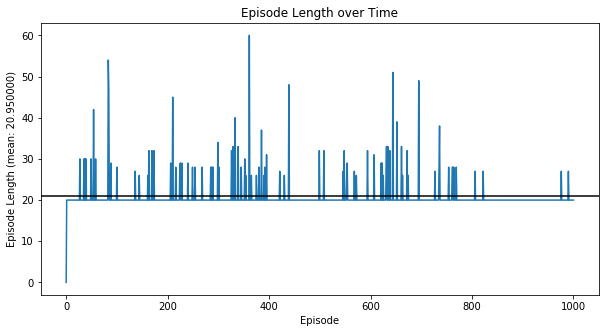

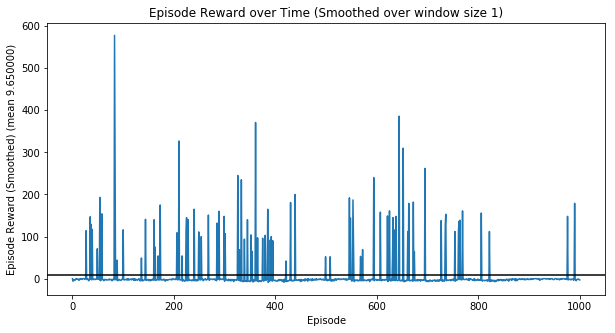

mean reward 9.65034965034965
standard deviation in reward 47.92647155489251


In [10]:
interactive = False
%matplotlib inline
episode_count = 1000
random.seed(42)
env = SimpleMarketingEnv(cust_list_gauss_050_035, cost_marketing_action=1)
agent = QLearningAgent(range(env.action_space.n), alpha=0.2, epsilon=0.1)
experiment = Experiment(env, agent)
stats = experiment.run_qlearning(episode_count, interactive)
agent.print_final_statistics()
print('mean reward', np.mean(stats.episode_rewards))
print('standard deviation in reward', np.std(stats.episode_rewards))

In [ ]:
# lower probability of response -- still learned?
interactive = False
%matplotlib inline
episode_count = 12000
env = SimpleMarketingEnv(cust_list_gauss_025_012, cost_marketing_action=1)
agent = QLearningAgent(range(env.action_space.n),  alpha=0.2, epsilon=0.06)
experiment = Experiment(env, agent)
experiment.run_qlearning(episode_count, interactive)
agent.print_final_statistics()

### Two different actions which could sell product

* Initially indistinguishable in effectiveness.  Maybe two products being offered for same price.

* We are not putting the end user in a distinct state dependent on the marketing action.  This assumption could be further debated.

In [ ]:
interactive = False
%matplotlib inline
episode_count =  5000

env = SimpleMarketingEnv(cust_list_gauss_050_035, cost_marketing_action=1)

#
# setup higher epsilon otherwise takes long time to learn
#
agent = QLearningAgent([0,1,2], epsilon=0.02)
experiment = Experiment(env, agent)
random.seed(42)
experiment.run_qlearning(episode_count, interactive)


## Does a Two Valued Marketing Enviornment Outperform?

In [ ]:
# Interactive version for demo
interactive = True
%matplotlib nbagg
episode_count = 10

env = TwoValueMarketingEnv(cust_list_gauss_050_035, p_initial_high=0, p_low_to_high=.5, p_high_to_low=.1)
agent = QLearningAgent(range(env.action_space.n), alpha=0.2, epsilon=0.06)
experiment = Experiment(env, agent)
random.seed(42)
experiment.run_qlearning(episode_count, interactive)


* Two value environment beats single valued environment even without knowledge of particular customer


In [ ]:
# Two value environment - winner
interactive = False
%matplotlib inline
episode_count = 10000
env = TwoValueMarketingEnv(cust_list_gauss_050_035, p_initial_high=0.3, p_low_to_high=.5, p_high_to_low=.1)
agent = QLearningAgent(range(env.action_space.n), alpha=0.2, epsilon=0.06)
experiment = Experiment(env, agent)
random.seed(42)
experiment.run_qlearning(episode_count, interactive)


In [ ]:
# Single value environment - loser
interactive = False
%matplotlib inline
episode_count = 10000
env = SimpleMarketingEnv(cust_list_gauss_050_035)
agent = QLearningAgent(range(env.action_space.n), alpha=0.2, epsilon=0.06)
experiment = Experiment(env, agent)
random.seed(42)
experiment.run_qlearning(episode_count, interactive)


In [ ]:
# Two value environment - modified
# try initial_high = 0.5 reflecting environment assumptions
interactive = False
%matplotlib inline
episode_count = 25000
env = TwoValueMarketingEnv(cust_list_gauss_050_035, p_initial_high=0.5, p_low_to_high=.5, p_high_to_low=.1)
agent = QLearningAgent(range(env.action_space.n), alpha=0.2, epsilon=0.06)
experiment = Experiment(env, agent)
random.seed(42)
experiment.run_qlearning(episode_count, interactive)


In [ ]:
# Two value environment - modified
# try initial_high = 0.5 reflecting environment assumptions
# try p_low_to_high = 1 to boost performers
#
# this did even better
interactive = False
%matplotlib inline
episode_count = 10000
env = TwoValueMarketingEnv(cust_list_gauss_050_035, p_initial_high=0.5, p_low_to_high=1.0, p_high_to_low=.1)
agent = QLearningAgent(range(env.action_space.n), alpha=0.2, epsilon=0.06)
experiment = Experiment(env, agent)
random.seed(42)
experiment.run_qlearning(episode_count, interactive)


In [ ]:
# Two value environment - modified
# try initial_high = 0.5 reflecting environment assumptions
# try p_low_to_high = 1 to boost performers
# try p_high_to_low = .2 to push down the non-performers -- this hurt performance
#
interactive = False
%matplotlib inline
episode_count = 25000
env = TwoValueMarketingEnv(cust_list_gauss_050_035, p_initial_high=0.5, p_low_to_high=1.0, p_high_to_low=.2)
agent = QLearningAgent(range(env.action_space.n), alpha=0.2, epsilon=0.06)
experiment = Experiment(env, agent)
random.seed(42)
experiment.run_qlearning(episode_count, interactive)


In [ ]:
# Two value environment - modified
# try initial_high = 0 to make person prove performance
# try p_low_to_high = 1 to boost performers
# try p_high_to_low = 0 to keep people at high once high
#
interactive = False
%matplotlib inline
episode_count = 25000

#
# should fix how cust list is used - make it a sequence
#

env = TwoValueMarketingEnv(cust_list_gauss_050_035, p_initial_high=0, p_low_to_high=1.0, p_high_to_low=0)
agent = QLearningAgent(range(env.action_space.n), alpha=0.2, epsilon=0.06)
experiment = Experiment(env, agent)
experiment.run_qlearning(episode_count, interactive)
